# 1. AutoInland Vehicle Insurance


In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

#2. Loading the files

In [ ]:
# Load files into a pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
ss = pd.read_csv('SampleSubmission.csv')
vd = pd.read_csv('VariableDefinitions.csv')
# loading the Nigerian states
states = pd.read_csv('NigerianStateNames.csv')

In [ ]:
vd

,ID,Unique ID for the customer
0,Policy Start Date,Date policy started
1,Policy End Date,Date policy ended
2,Gender,Gender of the customer
3,Age,Age of the customer
4,ProductName,Name of Insurance policy
5,First Transaction Date,First date payment was made
6,No_Pol,Number of policies the customer has
7,Car_Category,Type of car
8,Subject_Car_Colour,Car colour
9,Subject_Car_Make,Car make


# some basic EDA

In [ ]:
# Preview the first five rows of the train set
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [ ]:
train.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
12074,ID_ZZA1SES,2010-05-25,2011-05-24,Female,30,2010-05-25,1,NaN,Black,Range Rover,Ibeju/Lekki,Ibeju-Lekki,Car Classic,1
12075,ID_ZZDAC3K,2010-10-03,2011-10-02,Female,59,2010-10-03,1,NaN,NaN,NaN,NaN,NaN,Car Classic,0
12076,ID_ZZIU2XC,2010-10-10,2011-10-08,Male,34,2010-10-10,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
12077,ID_ZZRQ1NF,2010-02-27,2011-02-26,NaN,120,2010-02-27,2,NaN,White,TOYOTA,Victoria Island,Lagos,CVTP,0
12078,ID_ZZWRIIE,2010-07-01,2011-06-30,Female,46,2010-07-01,2,JEEP,Black,Land Rover,Lagos Island,Lagos,Car Classic,0


In [ ]:
# Preview the first five rows of the test set
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_009D84L,2010-04-24,2011-03-27,NO GENDER,25,2010-04-24,1,NaN,As Attached,Iveco,Victoria Island,Lagos,CVTP
1,ID_01DO2EQ,2010-01-01,2010-12-31,NaN,120,2010-01-01,4,NaN,As Attached,TOYOTA,Victoria Island,Lagos,Muuve
2,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
3,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
4,ID_02BYET3,2010-09-16,2010-12-31,NaN,120,2010-09-16,4,NaN,NaN,TOYOTA,Victoria Island,Lagos,Muuve


In [ ]:
# Preview ther first five rows of the sample submission file
ss.head()

,ID,target
0,ID_009D84L,0
1,ID_01DO2EQ,0
2,ID_01QM0NU,0
3,ID_024NJLZ,0
4,ID_02BYET3,0


In [ ]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (5177, 13)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


In [ ]:
train.describe(include="all")

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
count,12079,12079,12079,11720,12079.000000,12079,12079.000000,8341,5117,9603,5603,5591,12079,12079.000000
unique,12079,376,372,7,NaN,376,NaN,16,45,74,258,111,9,NaN
top,ID_5X93TAP,2010-03-27,2010-12-31,Male,NaN,2010-03-27,NaN,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN
freq,1,89,169,7617,NaN,89,NaN,6034,1880,4975,1162,3186,6485,NaN
mean,NaN,NaN,NaN,NaN,42.234539,NaN,1.307227,NaN,NaN,NaN,NaN,NaN,NaN,0.120457
std,NaN,NaN,NaN,NaN,97.492565,NaN,0.733085,NaN,NaN,NaN,NaN,NaN,NaN,0.325509
min,NaN,NaN,NaN,NaN,-6099.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,35.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,41.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,50.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5177 entries, 0 to 5176
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      5177 non-null   object
 1   Policy Start Date       5177 non-null   object
 2   Policy End Date         5177 non-null   object
 3   Gender                  5021 non-null   object
 4   Age                     5177 non-null   int64 
 5   First Transaction Date  5177 non-null   object
 6   No_Pol                  5177 non-null   int64 
 7   Car_Category            3539 non-null   object
 8   Subject_Car_Colour      2172 non-null   object
 9   Subject_Car_Make        4116 non-null   object
 10  LGA_Name                2395 non-null   object
 11  State                   2389 non-null   object
 12  ProductName             5177 non-null   object
dtypes: int64(2), object(11)
memory usage: 525.9+ KB


In [ ]:
test.describe(include="all")

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
count,5177,5177,5177,5021,5177.000000,5177,5177.000000,3539,2172,4116,2395,2389,5177
unique,5177,356,363,7,NaN,356,NaN,14,37,53,193,81,9
top,ID_Y1Y5CPS,2010-03-27,2010-12-31,Male,NaN,2010-03-27,NaN,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic
freq,1,39,81,3271,NaN,39,NaN,2578,788,2124,507,1364,2779
mean,NaN,NaN,NaN,NaN,43.710257,NaN,1.308287,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,22.439018,NaN,0.712004,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,-76.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,34.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,40.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,50.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


#Checking for missing data

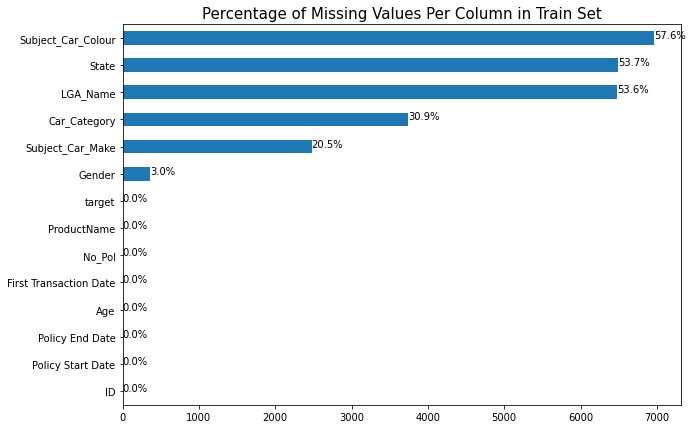

In [ ]:
# Check if there is any missing values in the train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
  percentage = '{:,.1f}%'.format((p.get_width()/train.shape[0])*100)
  width, height = p.get_width(), p.get_height()
  x = p.get_x() + width + 0.02
  y = p.get_y() + height/2
  ax.annotate(percentage, (x,y))

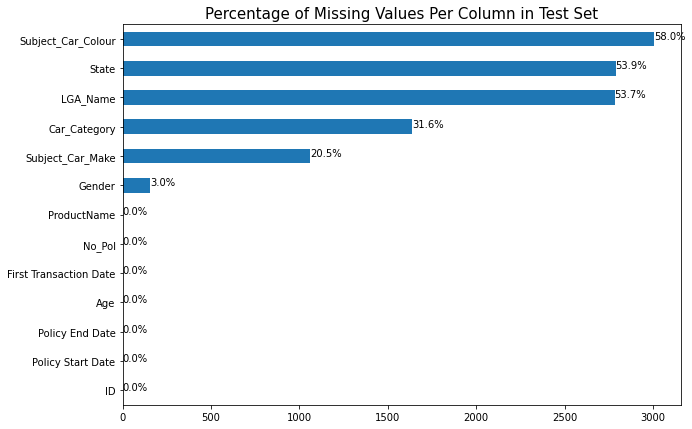

In [ ]:
# checking if there is missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
  percentage = '{:,.1f}%'.format((p.get_width()/test.shape[0])*100) 
  width, height = p.get_width(), p.get_height()
  x = p.get_x()+width+0.02
  y = p.get_y()+height/2
  ax.annotate(percentage, (x,y))

# Combine train and test set for easy preprocessing


In [ ]:
# Combine train and test set
ntrain = train.shape[0]  # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combinned dataframe is: {all_data.shape}')

The shape of the combinned dataframe is: (17256, 14)


In [ ]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
17251,ID_ZYXX5AF,2010-07-18,2011-07-17,Male,48,2010-07-18,1,Saloon,NaN,Honda,NaN,NaN,CarSafe,NaN
17252,ID_ZYYOZ5L,2010-12-04,2011-12-03,NaN,50,2010-12-04,1,NaN,NaN,NaN,Victoria Island,Lagos,Car Classic,NaN
17253,ID_ZZ1GTKD,2010-09-24,2011-09-23,Male,1,2010-09-24,1,NaN,NaN,NaN,NaN,NaN,CarSafe,NaN
17254,ID_ZZDXQSI,2010-07-17,2011-07-16,Female,52,2010-07-17,1,Saloon,Grey,TOYOTA,NaN,NaN,Car Classic,NaN
17255,ID_ZZYTLV1,2010-07-17,2011-07-16,Male,68,2010-07-17,1,Saloon,NaN,Peugeot,NaN,NaN,CarSafe,NaN


In [ ]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17256 entries, 0 to 17255
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      17256 non-null  object 
 1   Policy Start Date       17256 non-null  object 
 2   Policy End Date         17256 non-null  object 
 3   Gender                  16741 non-null  object 
 4   Age                     17256 non-null  int64  
 5   First Transaction Date  17256 non-null  object 
 6   No_Pol                  17256 non-null  int64  
 7   Car_Category            11880 non-null  object 
 8   Subject_Car_Colour      7289 non-null   object 
 9   Subject_Car_Make        13719 non-null  object 
 10  LGA_Name                7998 non-null   object 
 11  State                   7980 non-null   object 
 12  ProductName             17256 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [ ]:
# change each column to its appropriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data


,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17251,ID_ZYXX5AF,2010-07-18,2011-07-17,Male,48,2010-07-18,1,Saloon,NaN,Honda,NaN,NaN,CarSafe,NaN
17252,ID_ZYYOZ5L,2010-12-04,2011-12-03,NaN,50,2010-12-04,1,NaN,NaN,NaN,Victoria Island,Lagos,Car Classic,NaN
17253,ID_ZZ1GTKD,2010-09-24,2011-09-23,Male,1,2010-09-24,1,NaN,NaN,NaN,NaN,NaN,CarSafe,NaN
17254,ID_ZZDXQSI,2010-07-17,2011-07-16,Female,52,2010-07-17,1,Saloon,Grey,TOYOTA,NaN,NaN,Car Classic,NaN


# 5. Distribution of the target variable


Text(0.5, 1.0, 'Target Distribution')

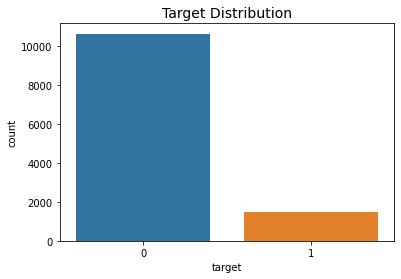

In [ ]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14})

# Distribution of the gender column

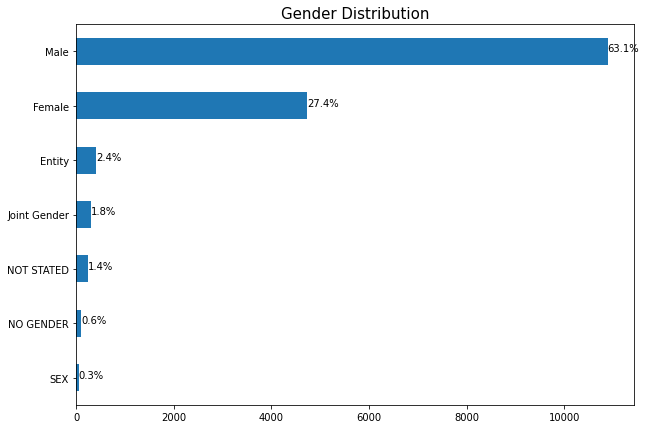

In [ ]:
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize= (10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage = '{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height = p.get_width(), p.get_height()
  x = p.get_x()+width+0.02
  y = p.get_y()+height/2
  ax.annotate(percentage,(x,y))

In [ ]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER':'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      10888
Female     4735
Other      1118
Name: Gender, dtype: int64

# Number of unique values per categorical columns

In [ ]:
# Check for unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

Gender
['Male' 'Female' 'Other' nan] 

Car_Category
['Saloon', 'JEEP', NaN, 'Motorcycle', 'Truck', ..., 'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck']
Length: 17
Categories (16, object): ['Saloon', 'JEEP', 'Motorcycle', 'Truck', ..., 'Shape Of Vehicle Chasis',
                          'Sedan', 'Station 4 Wheel', 'Tipper Truck'] 

Subject_Car_Colour
['Black', 'Grey', 'Red', NaN, 'As Attached', ..., 'Yellow & White', 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon']
Length: 47
Categories (46, object): ['Black', 'Grey', 'Red', 'As Attached', ..., 'Beige Mitalic',
                          'Light Gray', 'Blue Sky', 'Red Maroon'] 

Subject_Car_Make
['TOYOTA', NaN, 'REXTON', 'Lexus', 'Hyundai', ..., 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj', 'Datsun']
Length: 76
Categories (75, object): ['TOYOTA', 'REXTON', 'Lexus', 'Hyundai', ..., 'Buik', 'COMMANDER', 'Bajaj',
                          'Datsun'] 

LGA_Name
[NaN, 'Lagos', 'Ikeja', 'Badagry', 'Eti-Osa

# Filling in missing values

Missing values can be filled using different strategies
Tips:




*   Mean
*   Max
*   Min
*   sklearn SimpleImputer
*   Others... do more research




*   List item






In [ ]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mean())

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                       0
Car_Category              0
First Transaction Date    0
Gender                    0
ID                        0
LGA_Name                  0
No_Pol                    0
Policy End Date           0
Policy Start Date         0
ProductName               0
State                     0
Subject_Car_Colour        0
Subject_Car_Make          0
dtype: int64

Feature Engineering
A lot of features can be extracted from dates
Tips:


*   Quarterly, Start of Year, month
*   Is it a weekend, weekday
*   Is it holiday?
*   Duration between different periods, e.g start and end of a policy
*   What feature can be derived from the age column
*   Be creative



# Checking for outliers

In [ ]:
#sns.boxplot(all_data.Age)

In [ ]:
#df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [ ]:
# removing outliers using z-score
# from scipy import stats
# all_data = all_data[(np.abs(stats.zscore(all_data.Age)) < 3)]

In [ ]:
# sns.boxplot(all_data.Age)

In [ ]:
# all_data.Age.plot(kind='hist')

sns.boxplot(all_data.No_Pol)

In [ ]:
all_data.columns

Index(['ID', 'Policy Start Date', 'Policy End Date', 'Gender', 'Age',
       'First Transaction Date', 'No_Pol', 'Car_Category',
       'Subject_Car_Colour', 'Subject_Car_Make', 'LGA_Name', 'State',
       'ProductName', 'target'],
      dtype='object')

extracting duration feature from policy start and end dates

In [ ]:
# importing timedelta
from datetime import timedelta

# getting the duration between policy start date and end date
all_data['Duration'] = all_data['Policy End Date'] - all_data['Policy Start Date']

# getting the duration in days
all_data['Duration_days'] = all_data['Duration']/timedelta(days=1)

# getting the duration in hours
all_data['Duration_months'] = all_data['Duration']/ timedelta(hours=1)

# getting the duration in seconds
all_data['Duration_seconds'] = all_data['Duration']/timedelta(seconds=1)


In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17256 entries, 0 to 17255
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   ID                      17256 non-null  object         
 1   Policy Start Date       17256 non-null  datetime64[ns] 
 2   Policy End Date         17256 non-null  datetime64[ns] 
 3   Gender                  17256 non-null  object         
 4   Age                     17256 non-null  int64          
 5   First Transaction Date  17256 non-null  datetime64[ns] 
 6   No_Pol                  17256 non-null  int64          
 7   Car_Category            17256 non-null  category       
 8   Subject_Car_Colour      17256 non-null  category       
 9   Subject_Car_Make        17256 non-null  category       
 10  LGA_Name                17256 non-null  category       
 11  State                   17256 non-null  category       
 12  ProductName             17256 no

In [ ]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()    

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Duration,Duration_days,Duration_months,Duration_seconds,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,364 days,364.0,8736.0,31449600.0,2010,5,14,2011,5,13,2010,5,14
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,Victoria Island,Lagos,Car Classic,1.0,364 days,364.0,8736.0,31449600.0,2010,11,29,2011,11,28,2010,11,29
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,364 days,364.0,8736.0,31449600.0,2010,3,21,2011,3,20,2010,3,21
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,CarSafe,0.0,364 days,364.0,8736.0,31449600.0,2010,8,21,2011,8,20,2010,8,21
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Saloon,Black,TOYOTA,Lagos,Lagos,Muuve,1.0,124 days,124.0,2976.0,10713600.0,2010,8,29,2010,12,31,2010,8,29


In [ ]:
all_data.State = all_data.State.str.lower().str.replace('n-a', 'NaN')

In [ ]:
all_data.State.unique()

array(['lagos', 'benue', 'eti-osa', 'delta', 'ogun', 'abuja-municipal',
       'oshodi-isolo', 'ibeju-lekki', 'ibadan-west', 'obia-akpor',
       'ibadan-east', 'kaduna-south', 'amuwo-odofin', 'anambra', 'rivers',
       'niger-state', 'edo', 'akwa-ibom', 'enugu-east', 'abuja', 'kaduna',
       'esan-west', 'obafemi-owode', 'orile-iganmu', 'ifako-ijaye',
       'ibadan-north', 'imo', 'jos-north', 'ondo-west', 'kaduna-north',
       'aniocha-south', 'awka-south', 'ile-oluji', 'ijebu-ode',
       'port-harcourt', 'nnewi-north', 'aboh-mbaise', 'oyo', 'akoko-west',
       'warri-central', 'cross-river', 'jos-south', 'onitsha-north',
       'osun', 'ajeromi-ifelodun', 'kano-municipal', 'ife-central',
       'ilorin-west', 'lagelu-north', 'owerri-municipal', 'nsit-ubium',
       'udi-agwu', 'essien-udim', 'owerri-west', 'ondo', 'ogbmosho-south',
       'umuahia-south', 'abule-egba', 'enugu-north', 'ovia-southwest',
       'kebbi', 'ajegunle-state', 'ekiti-west', 'ogun-waterside',
       'ife

In [ ]:
states.State = states.State.str.lower().str.replace(' state', '')
states.State.unique()

array(['borno', 'federal capital territory', 'akwa ibom', 'ebonyi',
       'abia', 'ogun', 'cross river', 'imo', 'rivers', 'kogi', 'ekiti',
       'oyo', 'niger', 'benue', 'lagos', 'anambra', 'kano', 'gombe',
       'edo', 'ondo', 'nasarawa', 'kebbi', 'bauchi', 'enugu', 'delta',
       'zamfara', 'taraba', 'kwara', 'osun', 'jigawa', 'plateau',
       'katsina', 'yobe', 'sokoto', 'kaduna', 'bayelsa', 'adamawa',
       'capital-ogun', 'capital-fct', 'abuja-municipal-area-council',
       'alimosho', 'ado-odo-ota', 'ika-south', 'surulere', 'eti-osa',
       'oshodi-isolo', 'ajeromi-ifelodun', 'shomolu', 'capital-ondo',
       'ifo', 'state-akwa-ibom', 'agege', 'kosofe', 'obafemi-owode',
       'capital-delta', 'capital-anambra', 'ibeju-lekki', 'capital-edo',
       'capital-benue', 'capital-cross-river', 'central-benue',
       'lagos-mainland', 'uvwie', 'enugu-east', 'amuwo-odofin',
       'ifelodun', 'capital-oyo-central', 'ifako-ijaiye', 'apapa',
       'capital-lagos', 'ife-central', 

In [ ]:
all_data.LGA_Name = all_data.LGA_Name.str.lower().str.replace(' ','-')
all_data.LGA_Name.unique()

array(['victoria-island', 'lagos', 'ikeja', 'badagry', 'eti-osa', 'ikoyi',
       'lagos-mainland', 'effurun', 'abeokuta', 'abuja-municipal', 'yaba',
       'aguda', 'surulere', 'oshodi-isolo', 'alimosho',
       'okpe,-delta-state', 'asaba', 'ibadancentral', 'lekki',
       'ibeju/lekki', 'obanikoro', 'agege', 'isheri', 'kosofe', 'ogun',
       'apapa', 'ibadan-south-west', 'obia/akpor', 'ibadan-south-east',
       'sapele', 'kaduna-south', 'ikorodu', 'amuwo-odofin', 'awka',
       'gbagada', 'port-harcourt', 'minna', 'shomolu', 'benin',
       'lagos-island', 'central', 'ebute-metta', 'ketu', 'uyo', 'mushin',
       'katagum', 'enugu-east', 'oredo', 'abuja', 'festac', 'ipaja',
       'zaria-', 'esan-west', 'oluyole', 'bwari', 'obafemi-owode', 'lga',
       'orile-iganmu', 'egbeda', 'ido', 'ifako-ijaye-', 'ibadan-north',
       'oguta', 'jos-north', 'ajah', 'ondo-west', 'kaduna-north', 'warri',
       'aniocha-south', 'owerri', 'awka-south', 'asokoro-district',
       'ile-oluji', 'ij

In [ ]:
states.LGA = states.LGA.str.lower()
states.LGA.unique()

array(['abadam', 'abaji', 'abak', 'abakaliki', 'aba-north', 'aba-south',
       'abeokuta-north', 'abeokuta-south', 'abi', 'aboh-mbaise',
       'abua-odual', 'abuja-municipal-area-council', 'adavi', 'ado-ekiti',
       'ado-odo-ota', 'afijio', 'afikpo-north', 'afikpo-south--edda-',
       'agaie', 'agatu', 'agwara', 'agege', 'aguata', 'ahiazu-mbaise',
       'ahoada-east', 'ahoada-west', 'ajaokuta', 'ajeromi-ifelodun',
       'ajingi', 'akamkpa', 'akinyele', 'akko', 'akoko-edo',
       'akoko-north-east', 'akoko-north-west', 'akoko-south-west',
       'akoko-south-east', 'akpabuyo', 'akuku-toru', 'akure-north',
       'akure-south', 'akwanga', 'albasu', 'aleiro', 'alimosho',
       'alkaleri', 'amuwo-odofin', 'anambra-east', 'anambra-west',
       'anaocha', 'andoni', 'aninri', 'aniocha-north', 'aniocha-south',
       'anka', 'ankpa', 'apa', 'apapa', 'ado', 'ardo-kola', 'arewa-dandi',
       'argungu', 'arochukwu', 'asa', 'asari-toru', 'askira-uba',
       'atakunmosa-east', 'atakunmo

Deal with categorical variables

Tips:


*   One hot encoding
*   Label encoding
*   Target encoding
*   Reduce the number of unique values



In [ ]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,Duration,Duration_days,Duration_months,Duration_seconds,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday,Gender_Female,Gender_Male,Gender_Other,Car_Category_Bus,Car_Category_CAMRY CAR HIRE,Car_Category_JEEP,Car_Category_Mini Bus,Car_Category_Mini Van,Car_Category_Motorcycle,Car_Category_Pick Up,Car_Category_Pick Up > 3 Tons,Car_Category_Saloon,Car_Category_Sedan,Car_Category_Shape Of Vehicle Chasis,Car_Category_Station 4 Wheel,Car_Category_Tipper Truck,Car_Category_Truck,Car_Category_Van,Car_Category_Wagon,Subject_Car_Colour_As Attached,...,State_nsit-ubium,State_obafemi-owode,State_obia-akpor,State_ogba-ndoni,State_ogbmosho-south,State_ogun,State_ogun-waterside,State_ondo,State_ondo-west,State_onitsha-north,State_onitsha-south,State_orile-iganmu,State_oshimili-north,State_oshodi-isolo,State_osun,State_ovia-southwest,State_owerri-municipal,State_owerri-north,State_owerri-west,State_oyo,State_oyo-east,State_oyo-west,State_port-harcourt,State_quaan-pan,State_rivers,State_udi-agwu,State_ughelli-north,State_umuahia-south,State_warri-central,State_warri-north,State_warri-south,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,ID_0040R73,2010-05-14,2011-05-13,30,2010-05-14,1,0.0,364 days,364.0,8736.0,31449600.0,2010,5,14,2011,5,13,2010,5,14,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,79,2010-11-29,1,1.0,364 days,364.0,8736.0,31449600.0,2010,11,29,2011,11,28,2010,11,29,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,43,2010-03-21,1,0.0,364 days,364.0,8736.0,31449600.0,2010,3,21,2011,3,20,2010,3,21,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,ID_0079OHW,2010-08-21,2011-08-20,2,2010-08-21,1,0.0,364 days,364.0,8736.0,31449600.0,2010,8,21,2011,8,20,2010,8,21,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,ID_00BRP63,2010-08-29,2010-12-31,20,2010-08-29,3,1.0,124 days,124.0,2976.0,10713600.0,2010,8,29,2010,12,31,2010,8,29,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
all_data.drop(columns=['Policy Start Date', 'Policy End Date', 'First Transaction Date', 'Duration'], axis = 1, inplace=True)

In [ ]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 547), (5177, 547))

In [ ]:
train_df.isna().sum().sum()

0

In [ ]:
all_data.columns

Index(['ID', 'Age', 'No_Pol', 'target', 'Duration_days', 'Duration_months',
       'Duration_seconds', 'Policy Start Dateyear', 'Policy Start Datemonth',
       'Policy Start Dateday',
       ...
       'State_warri-south', 'ProductName_CVTP', 'ProductName_Car Classic',
       'ProductName_Car Plus', 'ProductName_Car Vintage',
       'ProductName_CarFlex', 'ProductName_CarSafe',
       'ProductName_Customized Motor', 'ProductName_Motor Cycle',
       'ProductName_Muuve'],
      dtype='object', length=547)

In [ ]:
all_data.target

0        0.0
1        1.0
2        0.0
3        0.0
4        1.0
        ... 
17251    NaN
17252    NaN
17253    NaN
17254    NaN
17255    NaN
Name: target, Length: 17256, dtype: float64

Training and making predictions

Tips:


*   Is lgbm the best model for this challenge
*   Parameter tuning

     * Grid Search, random search, perhaps bayesian search works better...







In [ ]:
train_df.target.isnull().sum()

0

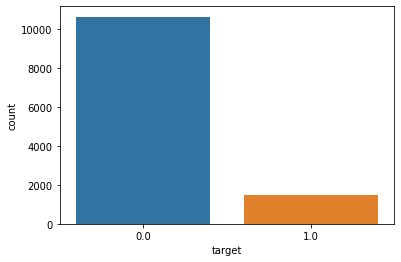

In [ ]:
sns.countplot(train_df.target)

In [ ]:
test_df.isna().sum().sum()

5177

In [ ]:
train_df.target = train_df.target.fillna(1.0)

In [ ]:
train_df.isna().sum().sum()

0

In [ ]:
train_df.shape

(12079, 547)

In [ ]:
train_df.Age.shape

(12079,)

In [ ]:
train_df.target.shape

(12079,)

# normalizing the dataset

In [ ]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(date_cols+['ID', 'target', 'Duration'])
X = train_df[main_cols]
y = train_df.target 

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42) 

# normalizing the dataset
from sklearn.preprocessing import MinMaxScaler
norm = MinMaxScaler()

X_train = norm.fit_transform(X_train)
X_test = norm.transform(X_test)

# Train model
model = LGBMClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Check the fi score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')

F1 score on the X_test is: 0.19217081850533807


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score 


In [ ]:
# dealing with the imbalanced data
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rfc_pred = rfc.predict(X_test)

In [ ]:
# xgboost
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train, y_train)
xg_pred =  xg.predict(X_test)


In [ ]:
# xgboost
from sklearn.neighbors import KNeighborsClassifier as KNN


knn = KNN()
knn.fit(X_train, y_train)
knn_pred =  knn.predict(X_test)


In [ ]:
results = pd.DataFrame({
    'Model': ['LightGBM', 'RandomForest', 'XGBoost', 'KNN'],
    'Accuracy Score': [accuracy_score(y_test, y_pred), accuracy_score(y_test, rfc_pred), 
                       accuracy_score(y_test, xg_pred), accuracy_score(y_test, knn_pred)],
    'Precision': [precision_score(y_test, y_pred), precision_score(y_test, rfc_pred), 
                  precision_score(y_test, xg_pred), precision_score(y_test, knn_pred) ],
    'Recall': [recall_score(y_test, y_pred), recall_score(y_test, rfc_pred),
               recall_score(y_test, xg_pred), recall_score(y_test, knn_pred)],
    'F1-score': [f1_score(y_test, y_pred), f1_score(y_test, rfc_pred),
                 f1_score(y_test, xg_pred), f1_score(y_test, knn_pred)]
    
    
})
results_df = results.sort_values(by='F1-score', ascending=False)
results_df = results.set_index('Model')
results_df

,Accuracy Score,Precision,Recall,F1-score
Model,,,,
LightGBM,0.874724,0.442623,0.122727,0.192171
RandomForest,0.850442,0.280172,0.147727,0.193452
XGBoost,0.881071,0.680000,0.038636,0.073118
KNN,0.865894,0.375000,0.156818,0.221154


In [ ]:
# random search
#print("Params that are currently in use")
#rfc.get_params()

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in rndom forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for (x)in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random Grid  
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# random_grid

In [ ]:
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)

In [ ]:
# rf_random.best_params_

In [ ]:
# rfc_model = RandomForestClassifier(bootstrap= True, max_depth= None, max_features= 'auto',
#                                   min_samples_leaf= 2, min_samples_split= 2, n_estimators= 1800)

In [ ]:
# rfc_model.fit(X_train, y_train)

In [ ]:
# pred = rfc_model.predict(X_test)

In [ ]:
rfc_model = RandomForestClassifier(class_weight='balanced')
rfc_model.fit(X_train, y_train)
pred = rfc_model.predict(X_test)

In [ ]:
print('Accuracy', accuracy_score(pred, y_test))
print('f1-score', f1_score(pred, y_test))
print('recall', recall_score(pred, y_test))
print('precision', precision_score(pred, y_test))

Accuracy 0.852924944812362
f1-score 0.24611032531824611
recall 0.3258426966292135
precision 0.19772727272727272


# Making predictions of the test set and creating  submission file


In [ ]:
test.shape

(5177, 13)

In [ ]:
test_df.shape

(5177, 547)

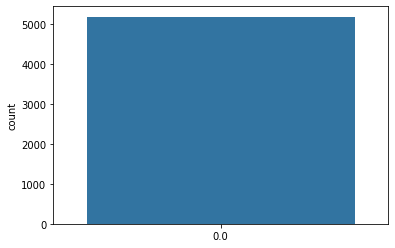

In [ ]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = rfc_model.predict(test_df)

# Create a submission file
sub_file = pd.DataFrame({"ID":test.ID, "target":predictions})
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions)


In [ ]:
# create a csv file to submit to zindi
sub_file.to_csv('Baseline6.csv', index = False)